<a href="https://colab.research.google.com/github/j-will7378/Cookie-Cats-A-B-Test/blob/main/cookie_cats_a_b_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problen Summary
Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level.

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention. But before we get to that, a key step before undertaking any analysis is understanding the data.

- **H0= one day and seven day retentions are the same**
- **Ha= one day and seven day retentions are not the same**

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# hypothesis testing
from scipy.stats import shapiro
import scipy.stats as stats

In [ ]:
df= pd.read_csv('/content/cookie_cats.csv')

In [ ]:
df.head(3)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False


In [ ]:
df['userid'].nunique() # number od unique plyers

90189

In [ ]:
pd.DataFrame(df['version'].value_counts()) # nimber of each version

,version
gate_40,45489
gate_30,44700


In [ ]:
df.groupby("version")[["userid"]].nunique() # number of plyers in each group

,userid
version,
gate_30,44700
gate_40,45489


In [ ]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [ ]:
90189*0.25

22547.25

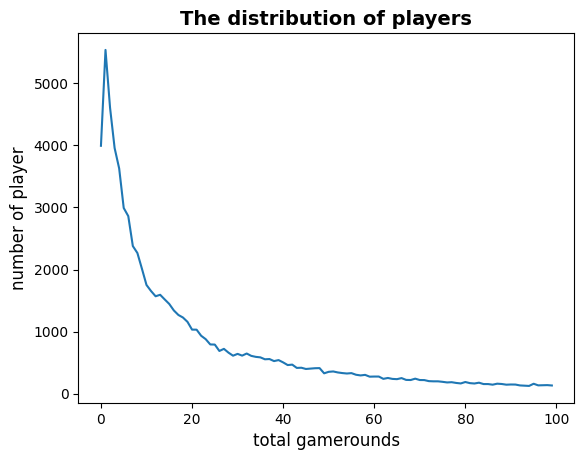

In [ ]:
# Counting the number of players for each number of gamerounds
plot_df = df.groupby("sum_gamerounds")["userid"].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(100).plot()
plt.title("The distribution of players", fontweight="bold", size=14)
plt.xlabel("total gamerounds", size=12)
plt.ylabel("number of player", size=12)
plt.show()

# Observation
There are plyers who downloaded the game and plyed zero rounds.

In [ ]:
df[df["sum_gamerounds"]== 0]["userid"].count() # number of plyers who played zero rounds

3994

In [ ]:
3994/90189 * 100

4.42847797403231

# Obsevation
3994 plyers down loaded the game an plyed no games. Is the too much or about what we expected?




In [ ]:
# what is the retention rate for one day and seven days.
df[["retention_1","retention_7"]].mean()*100

retention_1    44.520950
retention_7    18.606482
dtype: float64

# Observation
Retention drops as time passes. it might be good to see what the retion is after one month to see if the pattern still holds

In [ ]:
# see how retetion differs for bothe groups
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


# Observation
- There was a slight increase on day one vs day seven.
- A decrease of retention at day seven vs the controll group.
- The differences are small.

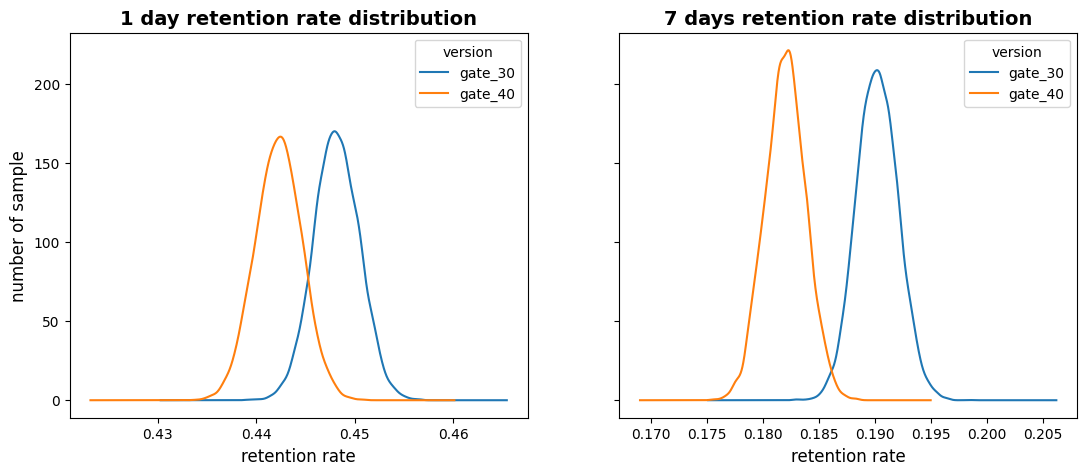

In [ ]:
# we do not know what the popuation mean or std are. We will use bootstrapping
# to resample the sample data to give us a population mean and std

# Creating an list with bootstrapped means for each A/B group
boot_1d = []
boot_7d = []
for i in range(10000):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)

# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retention rate",size=12)
ax1.set_ylabel("number of sample",size=12)
ax1.set_title("1 day retention rate distribution", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retention rate",size=12)
ax2.set_title("7 days retention rate distribution", fontweight="bold",size=14)
plt.show()

# Observation
These two distributions above represent the bootstrap uncertainty over what the underlying 1-day & 7-days retention could be for the two A/B groups. Just looking there is some evidence of a difference.

In [ ]:
import scipy.stats as stats

In [ ]:
# Set up contingency table
df_con = pd.DataFrame(data={'version': ['gate_30', 'gate_40']})
df_con['retained_1'] = df[df.retention_1==True].groupby(by='version').count()['retention_1'].values
df_con['nonretained_1'] = df[df.retention_1==False].groupby(by='version').count()['retention_1'].values
df_con['retained_7'] = df[df.retention_7==True].groupby(by='version').count()['retention_7'].values
df_con['nonretained_7'] = df[df.retention_7==False].groupby(by='version').count()['retention_7'].values
df_con

,version,retained_1,nonretained_1,retained_7,nonretained_7
0,gate_30,20034,24666,8502,36198
1,gate_40,20119,25370,8279,37210


In [ ]:
# Chi-squared test for 1-day retention
chi2, pvalue, _, _ = stats.chi2_contingency(df_con[['retained_1', 'nonretained_1']])
print('Test statistic: {}\np-value: {}'.format(chi2, pvalue))

Test statistic: 3.1591007878782262
p-value: 0.07550476210309086


In [ ]:
# Chi-squared test for 7-day retention
chi2, pvalue, _, _ = stats.chi2_contingency(df_con[['retained_7', 'nonretained_7']])
print('Test statistic: {}\np-value: {}'.format(chi2, pvalue))

Test statistic: 9.959086799559165
p-value: 0.0016005742679058301


# Conclusion

- **1-day retention:**
  There was a slight decrease in 1-day retention when the gate was moved from level 30 (44.8%) to level 40 (44.2%).
  However, according to our chi-squared test, there was no significant difference in retention rates between the two versions at the 5% significance level. We do not have enough evidence to reject our null hypothesis that retention rate is the same for the two versions.

- **7-day retention:**
  There was also a slight decrease in 7-day retention when the gate was moved from level 30 (19.0%) to level 40 (18.2%).
  According to our chi-squared test, there was a significant difference in retention rates at the 1% significance level. We reject our null hypothesis and accept our alternative hypothesis that 7-day retention rate is higher when the gate is at level 30.

#  Recomendations
- There is strong evidence that 7-day retention is higher when the first gate is at level 30 than when it is at level 40. We should not move the gate from level 30 to level 40.
- About 4.3% of players play zero rounds after inital download. 25% of playesrs played less than 5 rounds. There needs to be more investigation to under those behaviors.